In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import yfinance as yf
import talib as ta

from talib import RSI
from talib import MACD
from talib import STOCH
from talib import EMA
from talib import BBANDS

import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM
from keras.optimizers import Adam

In [2]:
SPY = yf.download('SPY', interval = '1d', prepost = False, repair = True)
SPYmin = yf.download('SPY', interval = '1m', prepost = False, repair = True)
SPYdy = yf.download('SPY', interval = '1d', prepost = False, repair = True)
SPYwk = yf.download('SPY', interval = '1wk', prepost = False, repair = True)
SPYmo = yf.download('SPY', interval = '1mo', prepost = False, repair = True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
def indicators(ticker):
    #Generates the indicators for the tickers
    data = ticker
    data['RSI'] = RSI(ticker.Close, 14)
    macd = MACD(ticker.Close, 12, 26, 9)
    data['macd'] = macd[0] * 100
    data['macdSignal'] = macd[1] * 100
    stoch = STOCH(ticker.High, ticker.Low, ticker.Close, fastk_period = 5, slowk_period = 3, slowd_period = 3)
    data['SlowK'] = stoch[0]
    data['SlowD'] = stoch[1]
    BB = BBANDS(ticker.Close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    data['BB'] = ((data.Close - BB[1]) * 100/(BB[2] - BB[1]))
    data['EMA'] = EMA(ticker.Close, timeperiod = 10)
    data['Direction'] = ((data.Close - data.Close.shift(1)) > 0).astype(int)
    data = data[['RSI', 'macd', 'macdSignal', 'SlowK', 'SlowD', 'BB', 'Direction']]
    return data

In [4]:
def shiftTrainAll(ticker, shift):
    data = ticker
    
    for days in range(shift):
        data['RSI' + str(days)] = None
        data['macd' + str(days)] = None
        data['macdSignal' + str(days)] = None
        data['SlowK' + str(days)] = None
        data['SlowD' + str(days)] = None
        data['BB' + str(days)] = None
        
    for index in range(shift, len(data)):
        date = data.index[index]
        for row in range(index - shift, index):
            counter = 6
            for days in range(shift):
                counter += 1
                data.iloc[index, counter] = data.RSI[date]
                counter += 1
                data.iloc[index, counter] = data.macd[date]
                counter += 1
                data.iloc[index, counter] = data.macdSignal[date]
                counter += 1
                data.iloc[index, counter] = data.SlowK[date]
                counter += 1
                data.iloc[index, counter] = data.SlowD[date]
                counter += 1
                data.iloc[index, counter] = data.BB[date]
                
    return data

In [5]:
def computeDirection(symbol):
    ticker = indicators(symbol)
    ticker = shiftTrainAll(ticker, 10)
    ticker.Direction = ticker.Direction.shift(-1)
    today =  ticker.iloc[-1,].to_frame().transpose() #Get current indicators to predict for the next move
    ticker = ticker.dropna()
    inputShape = ticker.columns.size - 1
    
    model = Sequential([
        Dense(16,  input_shape=(inputShape,), activation='relu'),
        Dense(16, activation = 'relu'),
        Dense(2, activation = 'softmax')
])
    
    model.compile(Adam(lr = 0.001), loss = 'mean_squared_error', metrics = ['accuracy'])
    
    #last 20% of the data will be used for testing
    testIndex = int(len(ticker)*0.8)
    train = ticker[:testIndex]
    test = ticker[testIndex:]
    test = pd.concat([test, today])#merging the current test dataframe with current (today) 
    
    #Using RSI, MACD and StochOsc for predicting the Direction
    #Only using the preivous day indicators to predict the nect move
    train_x = train.drop('Direction', axis = 1)
    train_y = pd.get_dummies(train['Direction']) #one hot encode for neural networks categorical
    test_x = test.drop('Direction', axis = 1)
    test_y = pd.get_dummies(test['Direction'])
    #converting to tensor format
    train_x = tf.convert_to_tensor(train_x.to_numpy(), dtype=tf.float32)
    train_y = tf.convert_to_tensor(train_y.to_numpy(), dtype=tf.float32)
    test_x = tf.convert_to_tensor(test_x.to_numpy(), dtype=tf.float32)
    test_y = tf.convert_to_tensor(test_y.to_numpy(), dtype=tf.float32)

    model.fit(train_x, train_y, epochs = 20, verbose = 1)
    
    pred_y = model.predict(test_x)
    pred_y = np.round(pred_y, decimals = 0)
    pred_y = pd.DataFrame(pred_y).idxmax(axis = 1)
    predtest_y = pd.DataFrame(test_y).idxmax(axis = 1)
    return pd.DataFrame({'pred': pred_y, 'true': predtest_y.reset_index(drop = True)})

In [6]:
day = computeDirection(SPYdy)

/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_26650/3478451163.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RSI' + str(days)] = None
/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_26650/3478451163.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['macd' + str(days)] = None
/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_26650/3478451163.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

Epoch 1/20


/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_26650/1843618889.py:28: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  test_y = pd.get_dummies(test['Direction'])


192/192 [==============================] - 0s 544us/step - loss: 0.5283 - accuracy: 0.4701
Epoch 2/20
192/192 [==============================] - 0s 495us/step - loss: 0.5234 - accuracy: 0.4752
Epoch 3/20
192/192 [==============================] - 0s 487us/step - loss: 0.5301 - accuracy: 0.4699
Epoch 4/20
192/192 [==============================] - 0s 488us/step - loss: 0.5301 - accuracy: 0.4699
Epoch 5/20
192/192 [==============================] - 0s 481us/step - loss: 0.5301 - accuracy: 0.4699
Epoch 6/20
192/192 [==============================] - 0s 478us/step - loss: 0.5301 - accuracy: 0.4699
Epoch 7/20
192/192 [==============================] - 0s 479us/step - loss: 0.5301 - accuracy: 0.4699
Epoch 8/20
192/192 [==============================] - 0s 483us/step - loss: 0.5301 - accuracy: 0.4699
Epoch 9/20
192/192 [==============================] - 0s 472us/step - loss: 0.5300 - accuracy: 0.4698
Epoch 10/20
192/192 [==============================] - 0s 479us/step - loss: 0.5301 - accurac

In [7]:
week = computeDirection(SPYwk)

/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_26650/3478451163.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RSI' + str(days)] = None
/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_26650/3478451163.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['macd' + str(days)] = None
/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_26650/3478451163.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

Epoch 1/20
39/39 [==============================] - 0s 591us/step - loss: 0.5337 - accuracy: 0.4623
Epoch 2/20
 1/39 [..............................] - ETA: 0s - loss: 0.4446 - accuracy: 0.5625

/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_26650/1843618889.py:28: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  test_y = pd.get_dummies(test['Direction'])


39/39 [==============================] - 0s 565us/step - loss: 0.4391 - accuracy: 0.5601
Epoch 3/20
39/39 [==============================] - 0s 573us/step - loss: 0.4425 - accuracy: 0.5561
Epoch 4/20
39/39 [==============================] - 0s 518us/step - loss: 0.4401 - accuracy: 0.5601
Epoch 5/20
39/39 [==============================] - 0s 525us/step - loss: 0.4425 - accuracy: 0.5569
Epoch 6/20
39/39 [==============================] - 0s 498us/step - loss: 0.4426 - accuracy: 0.5569
Epoch 7/20
39/39 [==============================] - 0s 509us/step - loss: 0.4415 - accuracy: 0.5577
Epoch 8/20
39/39 [==============================] - 0s 549us/step - loss: 0.4424 - accuracy: 0.5561
Epoch 9/20
39/39 [==============================] - 0s 535us/step - loss: 0.4461 - accuracy: 0.5537
Epoch 10/20
39/39 [==============================] - 0s 537us/step - loss: 0.4460 - accuracy: 0.5537
Epoch 11/20
39/39 [==============================] - 0s 535us/step - loss: 0.4471 - accuracy: 0.5529
Epoch 12/

In [17]:
month = computeDirection(SPYmo)

/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_26650/3478451163.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RSI' + str(days)] = None
/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_26650/3478451163.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['macd' + str(days)] = None
/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_26650/3478451163.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

Epoch 1/20
9/9 [==============================] - 0s 801us/step - loss: 0.3872 - accuracy: 0.6128
Epoch 2/20
9/9 [==============================] - 0s 822us/step - loss: 0.3872 - accuracy: 0.6128
Epoch 3/20
9/9 [==============================] - 0s 797us/step - loss: 0.3872 - accuracy: 0.6128
Epoch 4/20
1/9 [==>...........................] - ETA: 0s - loss: 0.4688 - accuracy: 0.5312

/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_26650/1843618889.py:28: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  test_y = pd.get_dummies(test['Direction'])


9/9 [==============================] - 0s 834us/step - loss: 0.3872 - accuracy: 0.6128
Epoch 5/20
9/9 [==============================] - 0s 842us/step - loss: 0.3872 - accuracy: 0.6128
Epoch 6/20
9/9 [==============================] - 0s 783us/step - loss: 0.3872 - accuracy: 0.6128
Epoch 7/20
9/9 [==============================] - 0s 824us/step - loss: 0.3872 - accuracy: 0.6128
Epoch 8/20
9/9 [==============================] - 0s 811us/step - loss: 0.3872 - accuracy: 0.6128
Epoch 9/20
9/9 [==============================] - 0s 844us/step - loss: 0.3872 - accuracy: 0.6128
Epoch 10/20
9/9 [==============================] - 0s 760us/step - loss: 0.3872 - accuracy: 0.6128
Epoch 11/20
9/9 [==============================] - 0s 721us/step - loss: 0.3872 - accuracy: 0.6128
Epoch 12/20
9/9 [==============================] - 0s 713us/step - loss: 0.3872 - accuracy: 0.6128
Epoch 13/20
9/9 [==============================] - 0s 729us/step - loss: 0.3872 - accuracy: 0.6128
Epoch 14/20
9/9 [==========

In [18]:
#For 16, 16 Dense Layer model
day['Accuracy'] = day['pred'] == day['true']
week['Accuracy'] = week['pred'] == week['true']
month['Accuracy'] = month['pred'] == month['true']

a = sum(day.Accuracy)/len(day.Accuracy)
b = sum(week.Accuracy)/len(week.Accuracy)
c = sum(month.Accuracy)/len(month.Accuracy)
print(f'Day: {a}, Week: {b}, Month: {c}')

Day: 0.4536553524804178, Week: 0.5623003194888179, Month: 0.6470588235294118


In [19]:
#For 16, 32 Dense Layer model
day['Accuracy'] = day['pred'] == day['true']
week['Accuracy'] = week['pred'] == week['true']
month['Accuracy'] = month['pred'] == month['true']

a = sum(day.Accuracy)/len(day.Accuracy)
b = sum(week.Accuracy)/len(week.Accuracy)
c = sum(month.Accuracy)/len(month.Accuracy)
print(f'Day: {a}, Week: {b}, Month: {c}')

Day: 0.4536553524804178, Week: 0.5623003194888179, Month: 0.6470588235294118


In [20]:
#The last row is the prediction for the next day
day.tail()

,pred,true,Accuracy
1527,0,0,True
1528,0,1,False
1529,0,0,True
1530,0,0,True
1531,0,0,True


In [21]:
#The last row is the prediction for the next week
week.tail()

,pred,true,Accuracy
308,1,1,True
309,1,1,True
310,1,0,False
311,1,1,True
312,1,0,False


In [22]:
#The last row is the prediction for the next month
month.tail()

,pred,true,Accuracy
63,1,1,True
64,1,1,True
65,1,1,True
66,1,0,False
67,1,0,False


In [23]:
#Calculation of accuracy in a function
def computeModel(symbol):
    ticker = indicators(symbol)
    ticker = shiftTrainAll(ticker, 10)
    ticker.Direction = ticker.Direction.shift(-1)
    today =  ticker.iloc[-1,].to_frame().transpose() #Get current indicators to predict for the next move
    ticker = ticker.dropna()
    inputShape = ticker.columns.size - 1
    
    model = Sequential([
        Dense(16,  input_shape=(inputShape,), activation='relu'),
        Dense(16, activation = 'relu'),
        Dense(2, activation = 'softmax')
])
    
    model.compile(Adam(lr = 0.001), loss = 'mean_squared_error', metrics = ['accuracy'])
    
    #last 20% of the data will be used for testing
    testIndex = int(len(ticker)*0.8)
    train = ticker[:testIndex]
    test = ticker[testIndex:]
    test = pd.concat([test, today])#merging the current test dataframe with current (today) 
    
    #Using RSI, MACD and StochOsc for predicting the Direction
    #Only using the preivous day indicators to predict the nect move
    train_x = train.drop('Direction', axis = 1)
    train_y = pd.get_dummies(train['Direction']) #one hot encode for neural networks categorical
    test_x = test.drop('Direction', axis = 1)
    test_y = pd.get_dummies(test['Direction'])
    #converting to tensor format
    train_x = tf.convert_to_tensor(train_x.to_numpy(), dtype=tf.float32)
    train_y = tf.convert_to_tensor(train_y.to_numpy(), dtype=tf.float32)
    test_x = tf.convert_to_tensor(test_x.to_numpy(), dtype=tf.float32)
    test_y = tf.convert_to_tensor(test_y.to_numpy(), dtype=tf.float32)

    model.fit(train_x, train_y, epochs = 20, verbose = 1)
    return model

def finalIndicatorTable(symbol):
    ticker = indicators(symbol)
    ticker = shiftTrainAll(ticker, 10)
    ticker.Direction = ticker.Direction.shift(-1)
    return ticker

def accuracyTester(ticker, model):
    testIndex = int(len(ticker)*0.8)
    train = ticker[:testIndex]
    test = ticker[testIndex:]
    
    train_x = train.drop('Direction', axis = 1)
    train_y = pd.get_dummies(train['Direction']) #one hot encode for neural networks categorical
    test_x = test.drop('Direction', axis = 1)
    test_y = pd.get_dummies(test['Direction'])
    #converting to tensor format
    train_x = tf.convert_to_tensor(train_x.to_numpy(), dtype=tf.float32)
    train_y = tf.convert_to_tensor(train_y.to_numpy(), dtype=tf.float32)
    test_x = tf.convert_to_tensor(test_x.to_numpy(), dtype=tf.float32)
    test_y = tf.convert_to_tensor(test_y.to_numpy(), dtype=tf.float32)
    
    pred_y = model.predict(test_x)
    pred_y = np.round(pred_y, decimals = 0)
    pred_y = pd.DataFrame(pred_y).idxmax(axis = 1)
    predtest_y = pd.DataFrame(test_y).idxmax(axis = 1)
    
    df = pd.DataFrame({'pred': pred_y, 'true': predtest_y.reset_index(drop = True)})
    
    df['Accuracy'] = df['pred'] == df['true']
    a = sum(df.Accuracy)/len(df.Accuracy)
    print(f'Accuracy is: {a}')
    
    return df

In [33]:
modelDaily = computeModel(SPYdy)

/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_26650/3478451163.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RSI' + str(days)] = None
/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_26650/3478451163.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['macd' + str(days)] = None
/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_26650/3478451163.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

Epoch 1/20


/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_26650/1236728191.py:29: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  test_y = pd.get_dummies(test['Direction'])


192/192 [==============================] - 0s 539us/step - loss: 0.4699 - accuracy: 0.5301
Epoch 2/20
192/192 [==============================] - 0s 490us/step - loss: 0.4699 - accuracy: 0.5301
Epoch 3/20
192/192 [==============================] - 0s 498us/step - loss: 0.4699 - accuracy: 0.5301
Epoch 4/20
192/192 [==============================] - 0s 496us/step - loss: 0.4699 - accuracy: 0.5301
Epoch 5/20
192/192 [==============================] - 0s 502us/step - loss: 0.4699 - accuracy: 0.5301
Epoch 6/20
192/192 [==============================] - 0s 492us/step - loss: 0.4699 - accuracy: 0.5301
Epoch 7/20
192/192 [==============================] - 0s 492us/step - loss: 0.4699 - accuracy: 0.5301
Epoch 8/20
192/192 [==============================] - 0s 488us/step - loss: 0.4699 - accuracy: 0.5301
Epoch 9/20
192/192 [==============================] - 0s 485us/step - loss: 0.4699 - accuracy: 0.5301
Epoch 10/20
192/192 [==============================] - 0s 488us/step - loss: 0.4699 - accurac

In [34]:
#Predicting the move for the next DAY
SPYtoday = yf.download('SPY', start = '2022-01-01', interval = '1d', prepost = False, repair = True)
SPYtodayx = finalIndicatorTable(SPYtoday)
accuracyTester(SPYtodayx, modelDaily)
#The last row is the prediction -> one hot encode for NaN is [0, 0]

[*********************100%***********************]  1 of 1 completed


/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_26650/3478451163.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RSI' + str(days)] = None
/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_26650/3478451163.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['macd' + str(days)] = None
/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_26650/3478451163.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

3/3 [==============================] - 0s 856us/step
Accuracy is: 0.5432098765432098


,pred,true,Accuracy
0,1,1,True
1,1,1,True
2,1,0,False
3,1,0,False
4,1,1,True
...,...,...,...
76,1,0,False
77,1,1,True
78,1,0,False
79,1,0,False


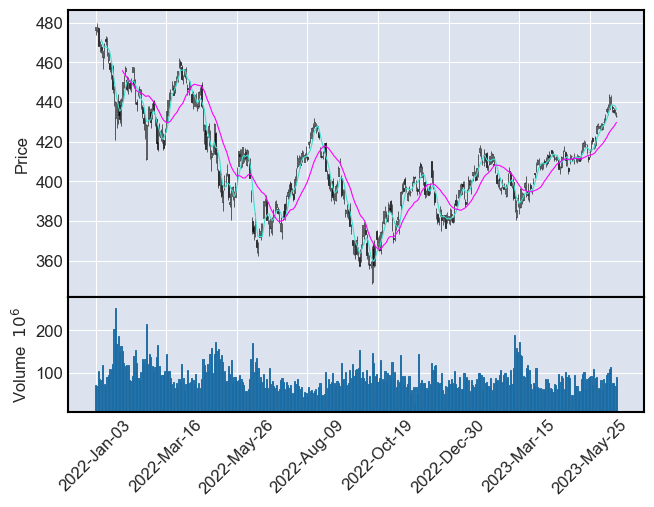

In [280]:
mpf.plot(SPYtoday, type = 'candle', mav = (5, 20), volume = True)